In [1]:
from PIL import Image
import os
import numpy as np
import time
from scipy.io import loadmat 
from matplotlib import pyplot as plt
import cv2 as cv

In [2]:
def block_matching(img_clean,img_noisy):
    S = 30
    f = 7
    f2 = f**2
    nv = 16
    s = 1
    img = np.pad(img_clean,((3,3),(3,3)),'edge')
    img_noisy = np.pad(img_noisy,((3,3),(3,3)),'edge')
    N = img.shape[0]-f+1
    M = img.shape[1]-f+1
    r = np.arange(0,N,s)
    c = np.arange(0,M,s)
    L = N*M
    X = np.zeros((f2,L))
    X_noisy = np.zeros((f2,L))
    k = -1
    for i in range(f):
        for j in range(f):
            k = k+1
            blk = img[i:N+i,j:M+j]
            X[k,:] = blk.reshape(-1)
            blk1 = img_noisy[i:N+i,j:M+j]
            X_noisy[k,:] = blk1.reshape(-1)
    I = np.arange(L)
    I = I.reshape(N,M)
    pos_arr = np.zeros((nv,N*M),dtype = 'int64')
    X = X.T
    X_noisy = X_noisy.T
    i = 0
    for row in range(N):
        for col in range(M):
            i = i+1
            if i%10000 == 0:
                print(str(i)+'/'+str(M*N))
            off = row*M+col
            rmin = max(row-S,0)
            rmax = min(row+S+1,N)
            cmin = max(col-S,0)
            cmax = min(col+S+1,M)
            idx = I[rmin:rmax,cmin:cmax]
            idx = idx.reshape(-1)
            B = X[idx,:]
            v = X[off,:]
            dis = np.linalg.norm((B-v),axis = 1,keepdims = True)/f2
            ind = np.argsort(dis,axis = None)
            indc = idx[ind[:16]]
            pos_arr[:,off] = indc
    return pos_arr.T,X,X_noisy

In [3]:
img_path = './001.png'
img_noisy_path = './002.png'
new_img_path = './new_img.png'
with open(img_path, 'rb') as f:
    img = Image.open(f)
    img = np.array(img)
with open(img_noisy_path,'rb') as f:
    img_noisy = Image.open(f)
    img_noisy = np.array(img_noisy)

In [5]:
img.shape

(256, 256, 3)

In [6]:
img = img[:,:,0]
img_noisy = img_noisy[:,:,0]
N,M = img.shape
img1 = img[0:N:2,0:M:2]
img_noisy1 = img_noisy[0:N:2,0:M:2]
img2 = img[0:N:2,1:M:2]
img_noisy2 = img_noisy[0:N:2,1:M:2]
img3 = img[1:N:2,0:M:2]
img_noisy3 = img_noisy[1:N:2,0:M:2]
img4 = img[1:N:2,1:M:2]
img_noisy4 = img_noisy[1:N:2,1:M:2]

In [6]:
img4.shape

(256, 256)

In [7]:
pos_arr,X,X_noisy = block_matching(img4,img_noisy4)

10000/16384


In [8]:
from scipy.io import savemat

In [9]:
savemat('pos_arr_new.mat',{'pos_arr':pos_arr})

In [10]:
pos_arr[0]

array([   0,    1,  128,    2,    7,  135,    6,    8,  134,  129, 2434,
       2306, 3484,  263, 3485,  262])

In [13]:
pos_arr[-10:]

array([[16374, 16354, 16246, 12516, 16226, 15334, 14330, 15206, 15076,
        16118, 16116, 14842, 12774, 15576, 15968, 15988],
       [16375, 16355, 16247, 15335, 16227, 14331, 16119, 13811, 15207,
        12517, 14819, 16117, 14323, 16099, 15859, 15079],
       [16376, 16356, 16248, 14332, 15336, 14074, 16228, 13812, 16120,
        13946, 14820, 16360, 15860, 13816, 14204, 15990],
       [16377, 16357, 16361, 16249, 16229, 13813, 16353, 16121, 15865,
        15857, 15579, 15853, 14813, 15861, 15451, 14075],
       [16378, 16362, 16358, 16250, 15866, 16366, 16122, 15854, 16230,
        13814, 16234, 15858, 14814, 15326, 15580, 16354],
       [16379, 16251, 15867, 16363, 16123, 16367, 15995, 15739, 14319,
        15327, 15197, 15855, 16235, 14191, 15069, 15347],
       [16380, 16252, 15868, 16368, 16364, 15740, 16124, 15996, 15612,
        16240, 14320, 15356, 15070, 16236, 15198, 16381],
       [16381, 16369, 16365, 16253, 15869, 14837, 16382, 15741, 15357,
        14321, 16241, 1278

In [6]:
# np.save('./pos_arr',pos_arr)

In [26]:
noisy = (X_noisy-X)/255
H,W= img4.shape
block_noisy_std = np.zeros((H*W,))
block_noisy_mean = np.zeros((H*W,))
for i in range(pos_arr.shape[0]):
    block_noisy_std[i] = np.std(noisy[pos_arr[i,:]])
    block_noisy_mean[i] = np.mean(noisy[pos_arr[i,:]])
block_noisy_std = block_noisy_std.reshape(H,W)
block_noisy_mean = block_noisy_mean.reshape(H,W)
new_img = img4/255 + np.random.normal(block_noisy_mean,block_noisy_std,block_noisy_std.shape)
if new_img.min() < 0:
    low_clip = 0.0
if new_img.max() >1:
    high_clip = 1.0
new_img = np.clip(new_img, low_clip, high_clip)
new_img = np.uint8(new_img*255)

In [8]:
new_img = Image.fromarray(new_img.astype('uint8'))

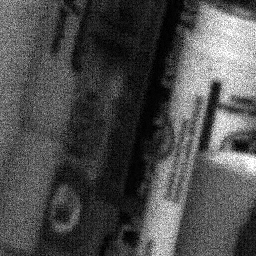

In [9]:
new_img

In [10]:
# new_img.save('./new_img.png')

In [11]:
test = Image.fromarray(img_noisy1.astype('uint8'))

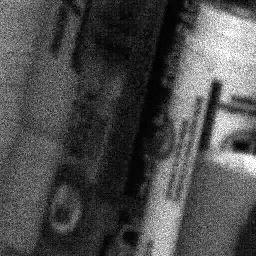

In [12]:
test

In [30]:
new_img = np.array(new_img)
img_test1 = new_img[:,:,np.newaxis]
img_test2 = img_noisy4[:,:,np.newaxis]
img_test = np.concatenate((img_test1,img_test2),axis = -1)

In [31]:
def image_hist(image): #画三通道图像的直方图
    color = ("blue", "green")#画笔颜色的值可以为大写或小写或只写首字母或大小写混合
    for i, color in enumerate(color):
        hist = cv.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=color)
        plt.xlim([0, 256])
#     plt.savefig("gener_noisy_step1.png")
    plt.show()

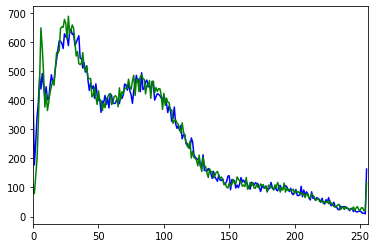

In [32]:
image_hist(img_test)

In [35]:
# new_img = np.array(new_img)
new_img = new_img.astype('int8')
img_noisy4 = img_noisy4.astype('int8')
img4 = img4.astype('int8')
noisy_gener = new_img - img4
noisy_true = img_noisy4 - img4

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


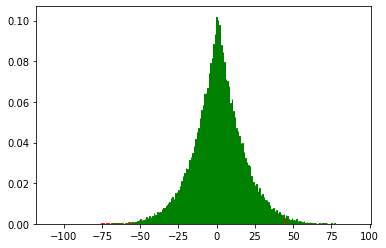

In [36]:
plt.figure("noisy_distribution1")
noisy_gener = noisy_gener.flatten()
plt.hist(noisy_gener, bins=512, normed=1,facecolor='r',edgecolor='r')
noisy_true = noisy_true.flatten()
plt.hist(noisy_true, bins=512, normed=1, facecolor='g',edgecolor='g')
plt.savefig("noisy_dis_step1.png")
plt.show()